# Lab 4 - Algorytmy Grupowania Danych

In [1]:
# Imports
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv("../dbs/abalone/abalone.data", header=None)
raw_df.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Opis zbioru danych

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).



## Kolumny w zbiorze danych

- Name / Data Type / Measurement Unit / Description

- Sex / nominal / -- / M, F, and I (infant) 
- Length / continuous / mm / Longest shell measurement
- Diameter	/ continuous / mm / perpendicular to length
- Height / continuous / mm / with meat in shell
- Whole weight / continuous / grams / whole abalone
- Shucked weight / continuous	 / grams / weight of meat
- Viscera weight / continuous / grams / gut weight (after bleeding)
- Shell weight / continuous / grams / after being dried
- Rings / integer / -- / +1.5 gives the age in years


In [3]:

# assign column names
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
           'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
raw_df.columns = columns
raw_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
X = raw_df
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

df = train_data.copy()

In [5]:
# AutoEDA
profile = ProfileReport(df, title="Abalone dataset EDA", explorative=True)
profile.to_file("abalone_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'I'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

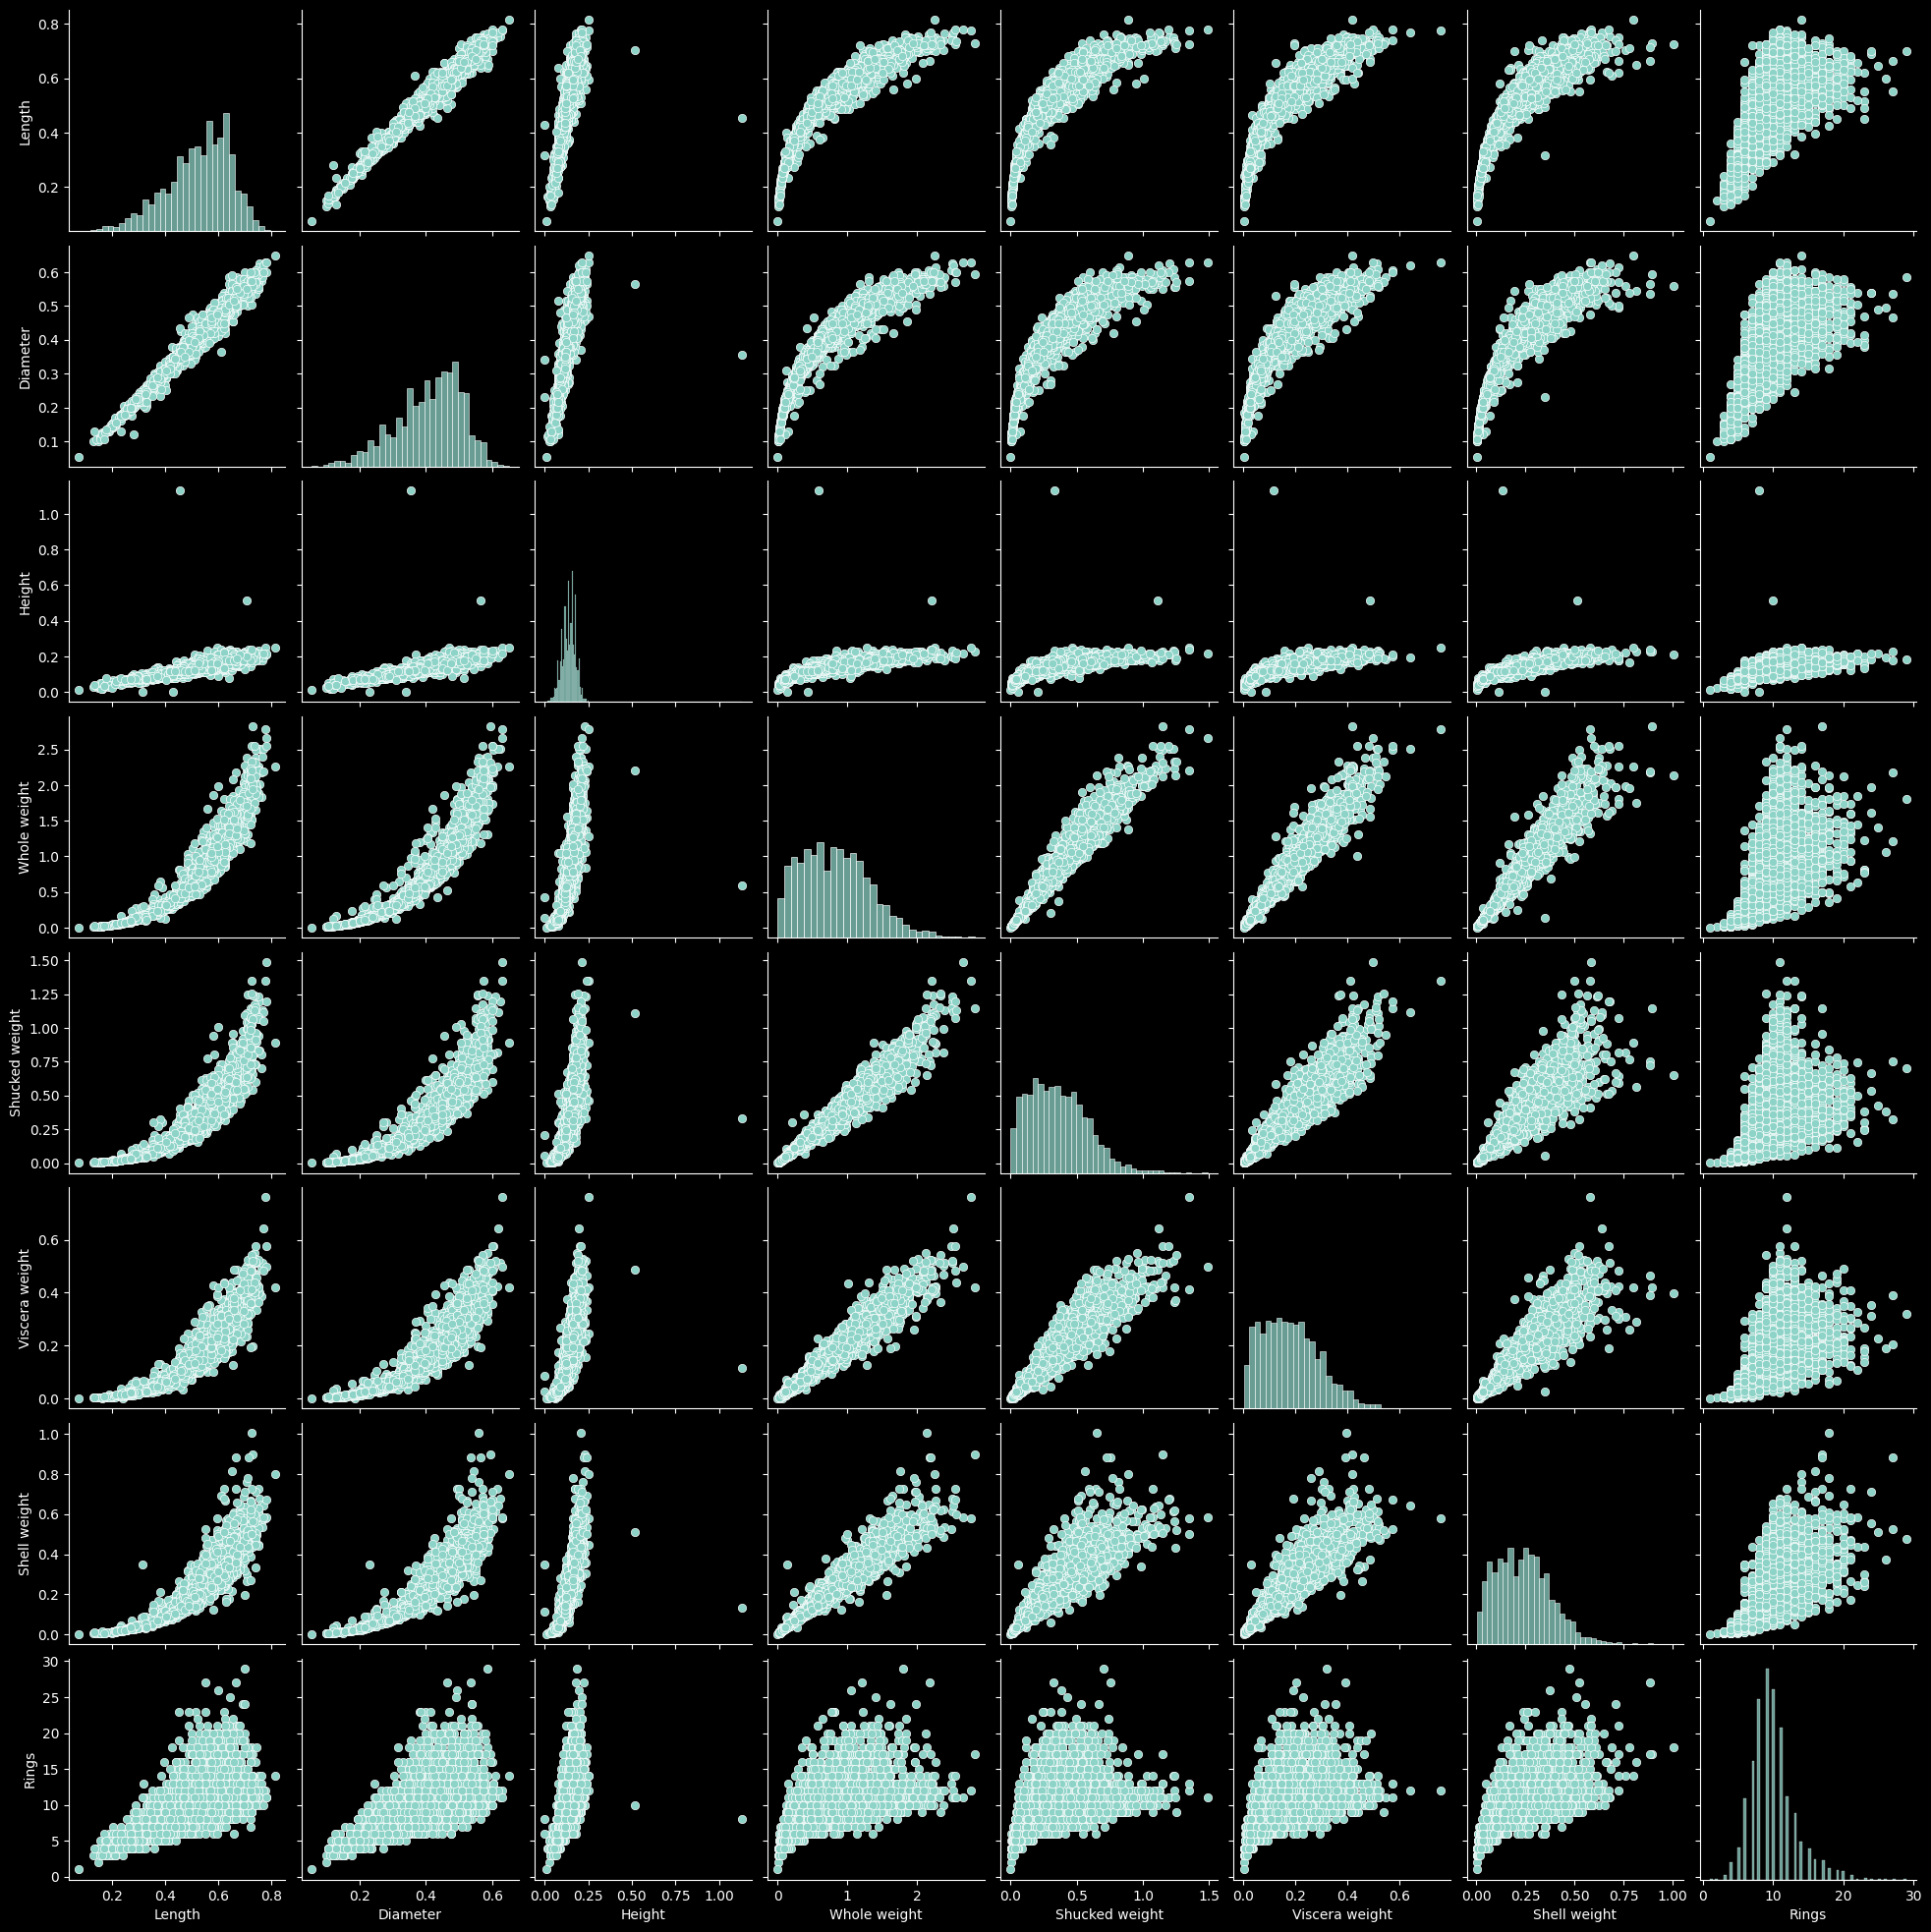

In [6]:
sns.pairplot(df)
plt.show()

## Wnioski EDA
Super zbiór, nie ma brakujących danych, powtarzających się wierszy itp.

Jedna kolumna kategoryczna: Sex

In [7]:
# Konwersja kategorii 'Sex' na zmienne numeryczne
df = pd.get_dummies(df, columns=['Sex'])

In [8]:
# Standaryzacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

data_scaled = pd.DataFrame(scaled_features, columns=df.columns[:])

In [9]:
# Detekcja outlierów
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(data_scaled)

outliers_pred = iso_forest.predict(data_scaled)

# Oznaczanie outlierów w zbiorze danych
data_scaled['outlier'] = outliers_pred
outliers = data_scaled[data_scaled['outlier'] == -1]

clean_data = data_scaled[data_scaled['outlier'] == 1]
clean_data.drop('outlier', axis=1, inplace=True)
data = clean_data.copy()

print("Wykryto outlierów:", len(outliers))
print("Liczba rekordów po usunięciu outlierów:", data.shape[0])


Wykryto outlierów: 334
Liczba rekordów po usunięciu outlierów: 3007


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_30070/3001230100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.drop('outlier', axis=1, inplace=True)


In [10]:
data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.210175,0.369725,-0.347950,-0.323164,-0.325407,-0.405130,-0.212132,0.329098,-0.67464,1.451863,-0.758909
1,-0.419444,-0.542386,-0.936082,-0.665985,-0.480126,-0.820932,-0.712419,-0.606395,-0.67464,1.451863,-0.758909
3,-2.098428,-2.113245,-1.759467,-1.453355,-1.363597,-1.533734,-1.462848,-0.918227,-0.67464,1.451863,-0.758909
4,-0.251546,-0.289022,-0.112697,-0.409632,-0.437522,-0.350299,-0.176398,0.640929,-0.67464,-0.688770,1.317680
5,-0.167597,-0.289022,-0.465577,-0.481859,-0.453219,-0.341161,-0.426541,-0.918227,-0.67464,1.451863,-0.758909


# Uruchomienie algorytmów grupowania

In [11]:
# K-Means Clustering
kmeans = KMeans(random_state=42)
kmeans_labels = kmeans.fit_predict(data)

silhouette_avg_kmeans = silhouette_score(data, kmeans_labels)
vrc_kmeans = calinski_harabasz_score(data, kmeans_labels)
db_index_kmeans = davies_bouldin_score(data, kmeans_labels)

print("K-means Clustering:")
print(f"Silhouette Score: {silhouette_avg_kmeans}")
print(f"Variance Ratio Criterion (VRC): {vrc_kmeans}")
print(f"Davies-Bouldin Index: {db_index_kmeans}")

K-means Clustering:
Silhouette Score: 0.3761007042832989
Variance Ratio Criterion (VRC): 2126.3408317802105
Davies-Bouldin Index: 1.04047341289208


In [12]:

# DBSCAN Clustering
dbscan = DBSCAN()
dbscan_labels = dbscan.fit_predict(data)

# Filter out noise points for silhouette score
core_samples_mask = dbscan_labels != -1

silhouette_avg_dbscan = silhouette_score(data[core_samples_mask], dbscan_labels[core_samples_mask])
vrc_dbscan = calinski_harabasz_score(data, dbscan_labels)
db_index_dbscan = davies_bouldin_score(data, dbscan_labels)

print("\nDBSCAN Clustering:")
print(f"Silhouette Score: {silhouette_avg_dbscan}")
print(f"Variance Ratio Criterion (VRC): {vrc_dbscan}")
print(f"Davies-Bouldin Index: {db_index_dbscan}")


DBSCAN Clustering:
Silhouette Score: 0.1811921933886989
Variance Ratio Criterion (VRC): 270.7832648133524
Davies-Bouldin Index: 1.4405206451808217


# Wizualizacja wyników grupowania

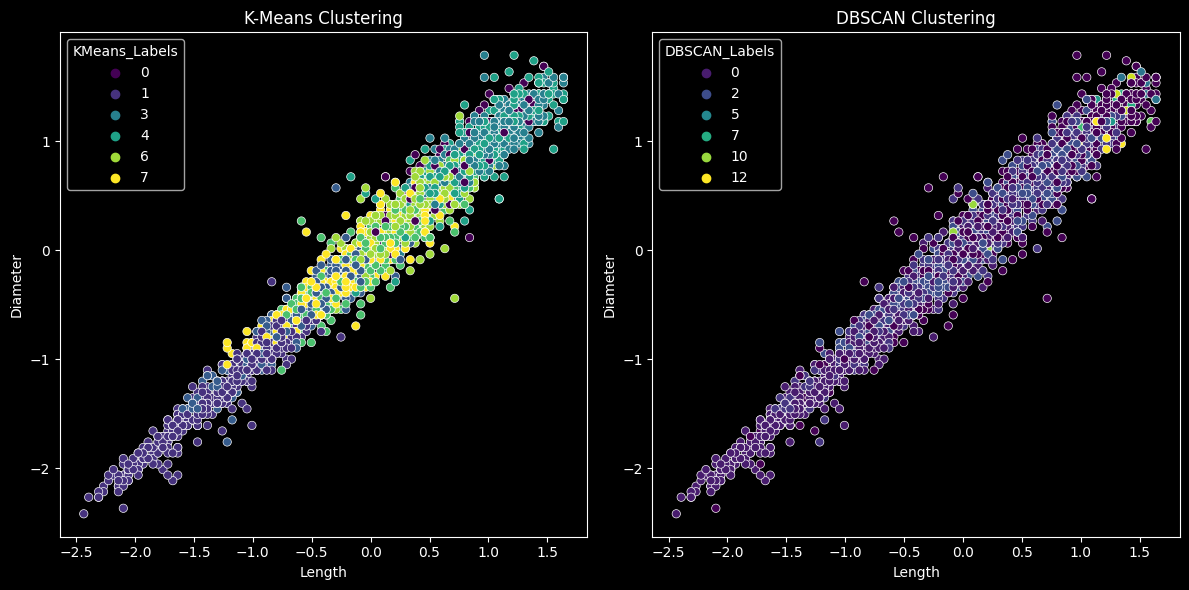

In [13]:
# Wybór zmiennych do wizualizacji
visual_data = data
visual_data['KMeans_Labels'] = kmeans_labels
visual_data['DBSCAN_Labels'] = dbscan_labels

feature1 = 'Length'
feature2 = 'Diameter'

# Wizualizacja dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=feature1, y=feature2, hue='KMeans_Labels', data=visual_data, palette='viridis')
plt.title('K-Means Clustering')

# Wizualizacja dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=feature1, y=feature2, hue='DBSCAN_Labels', data=visual_data, palette='viridis')
plt.title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

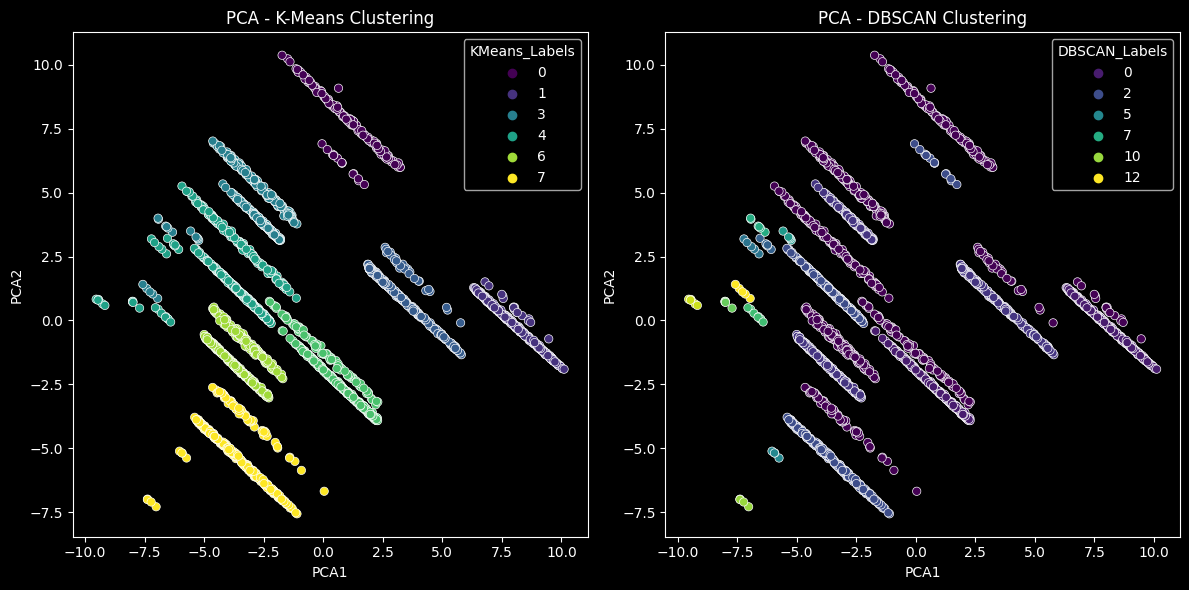

In [24]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Wizualizacja PCA dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=data['PCA1'], y=data['PCA2'], hue=visual_data['KMeans_Labels'], palette='viridis')
plt.title('PCA - K-Means Clustering')

# Wizualizacja PCA dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=data['PCA1'], y=data['PCA2'], hue=visual_data['DBSCAN_Labels'], palette='viridis')
plt.title('PCA - DBSCAN Clustering')

plt.tight_layout()
plt.show()


# Analiza hiperparametrów

### Analiza KMeans

Jedynym hiperparametrem jest liczba klastrów. 

In [15]:
silhouette_scores = []     # mierzy, jak bardzo punkt jest podobny do punktów w swoim klastrze w porównaniu do punktów z innych klastrów.
davies_bouldin_scores = [] # mierzy średnią odległość pomiędzy klastrami.
vrc_scores = []            # mierzy stosunek sumy odległości wewnątrz klastrów do odległości między klastrami.

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_features, labels))
    vrc_scores.append(calinski_harabasz_score(scaled_features, labels))

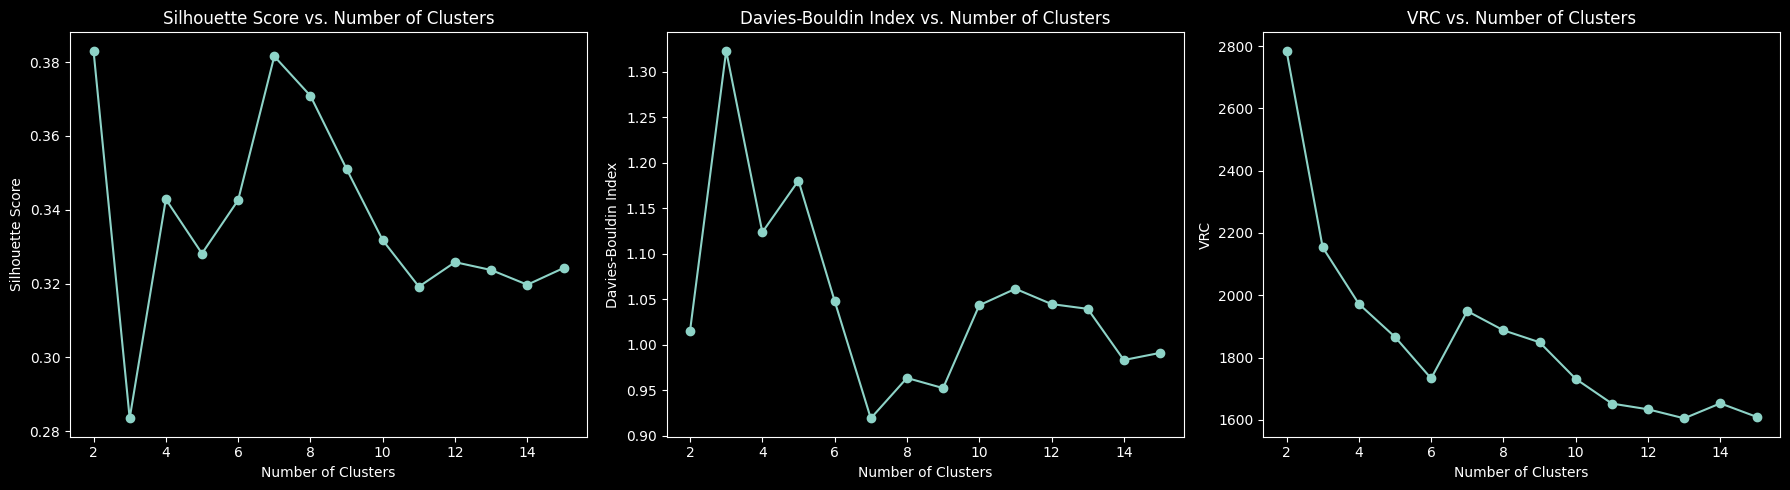

In [16]:

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(2, 16), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(range(2, 16), davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 3, 3)
plt.plot(range(2, 16), vrc_scores, marker='o')
plt.title('VRC vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('VRC')
plt.tight_layout()
plt.show()

Wyniki:
- Najwyższa wartość miary `silhouette_score` jest dla 2 klastrów.
- Najniższa wartość miary `davies_bouldin_score` jest dla 2 klastrów.
- Najwyższa wartość miary `calinski_harabasz_score` jest dla 2 klastrów.

Wybieramy więc 2 klastry

In [17]:
best_kmeans = KMeans(n_clusters=2, random_state=42)
best_kmeans_labels = best_kmeans.fit_predict(scaled_features)

silhouette_avg_kmeans = silhouette_score(scaled_features, best_kmeans_labels)
vrc_kmeans = calinski_harabasz_score(scaled_features, best_kmeans_labels)
db_index_kmeans = davies_bouldin_score(scaled_features, best_kmeans_labels)

print("K-means Clustering:")
print(f"Silhouette Score: {silhouette_avg_kmeans}")
print(f"Variance Ratio Criterion (VRC): {vrc_kmeans}")
print(f"Davies-Bouldin Index: {db_index_kmeans}")

K-means Clustering:
Silhouette Score: 0.3830764700501812
Variance Ratio Criterion (VRC): 2784.928764397764
Davies-Bouldin Index: 1.014979805727195


### Analiza DBSCAN

Hiperparametry
- `eps` - maksymalna odległość między dwoma próbkami, aby były one uważane za sąsiadów.
- `min_samples` - liczba próbek w otoczeniu punktu, aby go uważać za rdzeń.


In [18]:
# Testowanie różnych wartości eps i min_samples
eps_values = np.arange(0.2, 1.0, 0.1)
eps_values = np.round(eps_values, 1)
min_samples_values = range(2, 10)
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data.drop(['Rings'], axis=1))

        silhouette_avg = silhouette_score(data.drop(['Rings'], axis=1), labels)
        davies_bouldin = davies_bouldin_score(data.drop(['Rings'], axis=1), labels)
        calinski_harabasz = calinski_harabasz_score(data.drop(['Rings'], axis=1), labels)

        results.append((eps, min_samples, silhouette_avg, davies_bouldin, calinski_harabasz))

        
# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette_score', 'davies_bouldin', 'calinski_harabasz'])

# Pivot table for better visualization
pivot_table_silhouette_score = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')
pivot_table_davies_bouldin = results_df.pivot(index='min_samples', columns='eps', values='davies_bouldin')
pivot_table_calinski_harabasz = results_df.pivot(index='min_samples', columns='eps', values='calinski_harabasz')

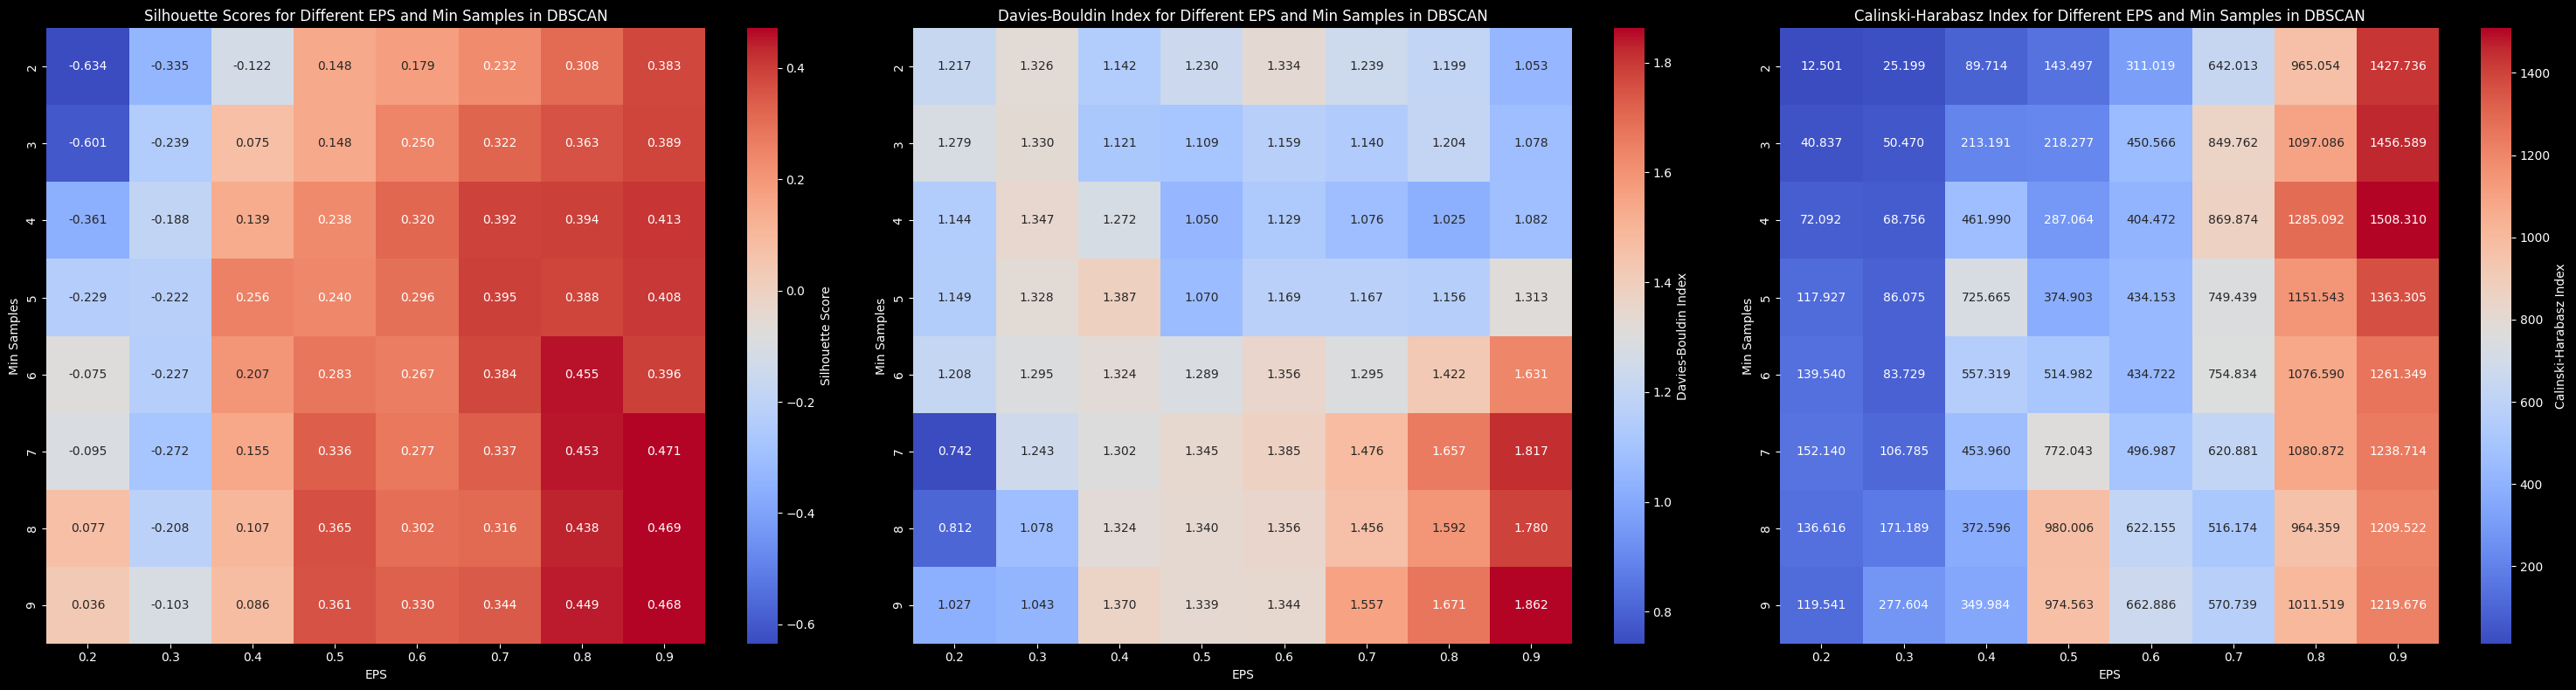

In [19]:
# Heatmap of the results
plt.figure(figsize=(30, 8))

plt.subplot(1, 3, 1)
sns.heatmap(pivot_table_silhouette_score, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'Silhouette Score'})
plt.title('Silhouette Scores for Different EPS and Min Samples in DBSCAN')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
# plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.heatmap(pivot_table_davies_bouldin, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'Davies-Bouldin Index'})
plt.title('Davies-Bouldin Index for Different EPS and Min Samples in DBSCAN')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
# plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(pivot_table_calinski_harabasz, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'Calinski-Harabasz Index'})
plt.title('Calinski-Harabasz Index for Different EPS and Min Samples in DBSCAN')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Wyniki:
- Najwyższe wartości miary `silhouette_score` są dla:
    - Wysokich wartości `eps` 
    - Wysokich wartości `min_samples`
- Najniższe wartości miary `davies_bouldin_score` są dla:
    - Niskich wartości `eps` i wysokich wartości `min_samples`
    - Wysokich wartości `eps` i niskich wartości `min_samples`
- Najwyższe wartości miary `calinski_harabasz_score` są dla:
    - Wysokich wartości `eps` 
    - Średnich wartości `min_samples`

Wybieram więc `eps=0.9` i `min_samples=6` gdyż daje to wysokie wyniki miar `silhouette_score` i `calinski_harabasz_score` oraz w miarę niskie wyniki miary `davies_bouldin_score`.

In [25]:
best_dbscan = DBSCAN(eps=0.9, min_samples=6)
best_dbscan_labels = best_dbscan.fit_predict(scaled_features)

silhouette_avg_dbscan = silhouette_score(scaled_features[core_samples_mask], best_dbscan_labels[core_samples_mask])
vrc_dbscan = calinski_harabasz_score(scaled_features[core_samples_mask], best_dbscan_labels[core_samples_mask])
db_index_dbscan = davies_bouldin_score(scaled_features[core_samples_mask], best_dbscan_labels[core_samples_mask])

print(f'{len(np.unique(best_dbscan_labels))-1} clusters')
print("DBSCAN Clustering:")
print(f"Silhouette Score: {silhouette_avg_dbscan}")
print(f"Davies-Bouldin Index: {db_index_dbscan}")
print(f"Variance Ratio Criterion (VRC): {vrc_dbscan}")

3 clusters
DBSCAN Clustering:
Silhouette Score: 0.3693854376474964
Davies-Bouldin Index: 1.1938061732258338
Variance Ratio Criterion (VRC): 1663.8626654158666


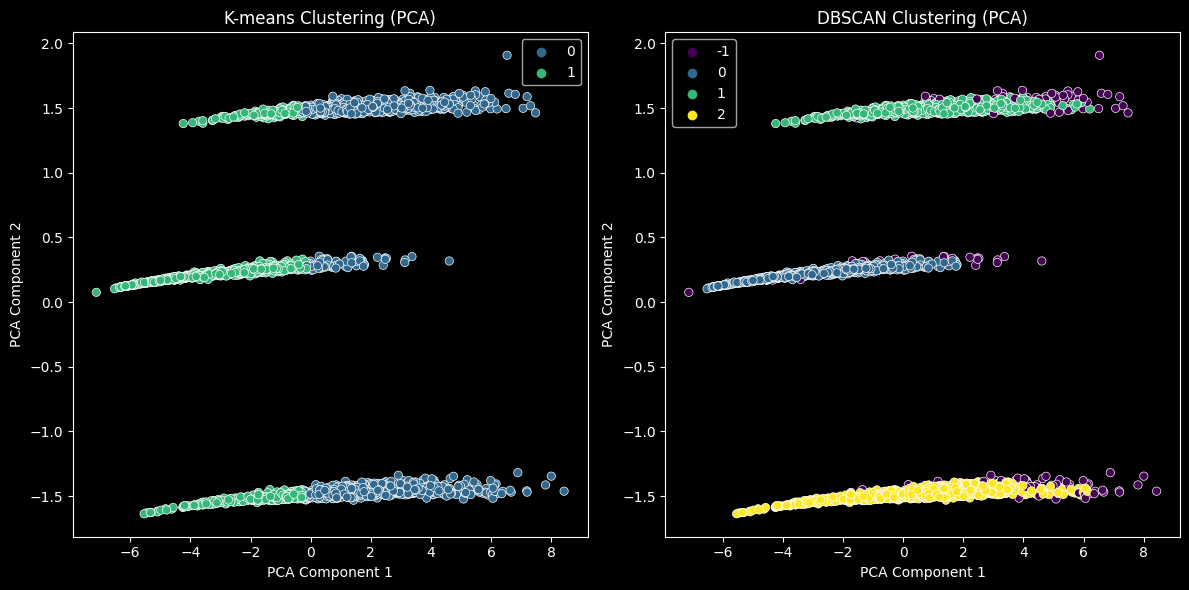

In [22]:
# PCA for best K-means and DBSCAN

# K-means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=best_kmeans_labels, palette='viridis')
plt.title('K-means Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=best_dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()